# Feature Selection for Disease Prediction

This notebook documents the feature selection process used to reduce dimensionality and identify interpretable, high-impact features for downstream predictive modeling and causal discovery. We explore multiple complementary strategies for robust and meaningful selection.

## Dataset

The data is sourced from the NHANES 2021–2023 survey, which includes a wide range of health, demographic, lifestyle, dietary, and laboratory variables.

Each target disease (e.g., diabetes, cardiovascular disease, kidney disease) is defined based on self-reported diagnoses or clinical measurements.

## Methods for Feature Selection

We apply the following four strategies:

### 1. **Domain Knowledge-Based Selection**
- Based on literature and clinical guidelines
- Includes known risk factors (e.g., age, BMI, glucose, blood pressure, physical activity, diet)

### 2. **Model-Based Importance**
- Trained models: Random Forest, XGBoost, LightGBM, Logistic Regression
- Extracted top features based on:
  - Tree-based feature importance scores
  - Logistic regression coefficients

### 3. **Correlation with Target**
- Calculated absolute Pearson correlation between each feature and the binary outcome
- Selected top-k most strongly correlated variables

### 4. **LASSO Regularization**
- Applied Logistic Regression with L1 penalty
- Retained features with non-zero coefficients



---
# Diabetes
---

In [1]:
import joblib 

diagnosis = 'diabetes'

loaded_model = joblib.load("saved_models/XGBoost_diabetes.pkl")
feature_names = joblib.load("saved_models/diabetes_feature_names.pkl")

importances = loaded_model.feature_importances_
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Model  importance
model_based_features=[]
for feature, importance in feature_importance[:50]:
    model_based_features.append(feature)

# Correlation based
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import re
from sklearn.impute import KNNImputer, SimpleImputer
from dataset_processing import get_columns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import joblib

# Load dataset
df = pd.read_csv('NHANES_SAMPLE.csv')

# Define target column
target_column, remove_list = get_columns('diab')

# Ensure target column exists
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset!")

# Handle missing target values
df = df.dropna(subset=[target_column])

# Convert target column to binary classification (1 = diabetes, else 0)
df[target_column] = df[target_column].apply(lambda x: 1 if x == 1 else 0)

# Convert all byte-string values to normal strings
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Select all feature columns (excluding target)
feature_columns = [col for col in df.columns if col != target_column]
feature_columns = [col for col in df.columns if col not in remove_list]

# Define activity columns to combine
activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]
# Combine activity columns
for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        combined_col = f"{freq_col}_combined"
        df[combined_col] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)
        df.drop([freq_col, unit_col], axis=1, inplace=True)
        feature_columns.remove(freq_col)
        feature_columns.remove(unit_col)
        feature_columns.append(combined_col)


df =df[feature_columns]

# Separate categorical and numerical columns
categorical_cols = df[feature_columns].select_dtypes(include=['object']).columns.tolist()
numerical_cols = [col for col in feature_columns if col not in categorical_cols]

from sklearn.preprocessing import OrdinalEncoder

# Initialize the encoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Encode only the categorical columns
df[categorical_cols] = ordinal_encoder.fit_transform(df[categorical_cols]) + 1  # shift to start at 1

# Save the encoder for future use if needed

# Handle missing values using KNN imputer
knn_imputer = KNNImputer(n_neighbors=3) 
# df.fillna(df.median(), inplace=True)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)

df.columns = [col.replace("_", "") for col in df.columns]
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = df.drop(columns=[target_column])

y = df[target_column]

X_corr = X.copy()
X_corr[target_column] = y

# Compute correlation with target
correlations = X_corr.corr(numeric_only=True)[target_column].abs()

# Select top-k features based on correlation
top_k = 50
top_corr_features = correlations.sort_values(ascending=False).head(top_k).index.tolist()

# Remove the target itself from the list
top_corr_features = [f for f in top_corr_features if f != target_column]


# Lasso - based 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Lasso (L1) Logistic Regression
lasso = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, C=0.01, random_state=42)
lasso.fit(X_scaled, y)

# Extract non-zero coefficients
lasso_selected_features = X.columns[(lasso.coef_ != 0).ravel()].tolist()


# Domain-based knowledge
domain_based_features = pd.read_csv('diabetes.csv')
domain_based_features=domain_based_features['column'].tolist()

for col in X.columns:
    if 'combined' in col:
        domain_based_features.append(col)

activity_columns = ["PAD790Q", "PAD790U", "PAD810Q", "PAD810U"]

for col in activity_columns:
    domain_based_features.remove(col)

/tmp/ipykernel_3799306/2834323789.py:88: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)


In [2]:
from functools import reduce

# Collect all methods
feature_sets = {
    "Model-Based": model_based_features,  # already extracted and saved
    "Domain": domain_based_features,
    "Correlation": top_corr_features,
    "LASSO": lasso_selected_features,
}

# Intersection of features across methods
# intersection = list(set.intersection(*map(set, feature_sets.values())))
# print(f"\nFeatures selected by all methods ({len(intersection)}):", intersection)

# Union of all features
union = list(set.union(*map(set, feature_sets.values())))
print(f"\nTotal unique features selected across all methods ({len(union)}):", len(union))



Total unique features selected across all methods (107): 107


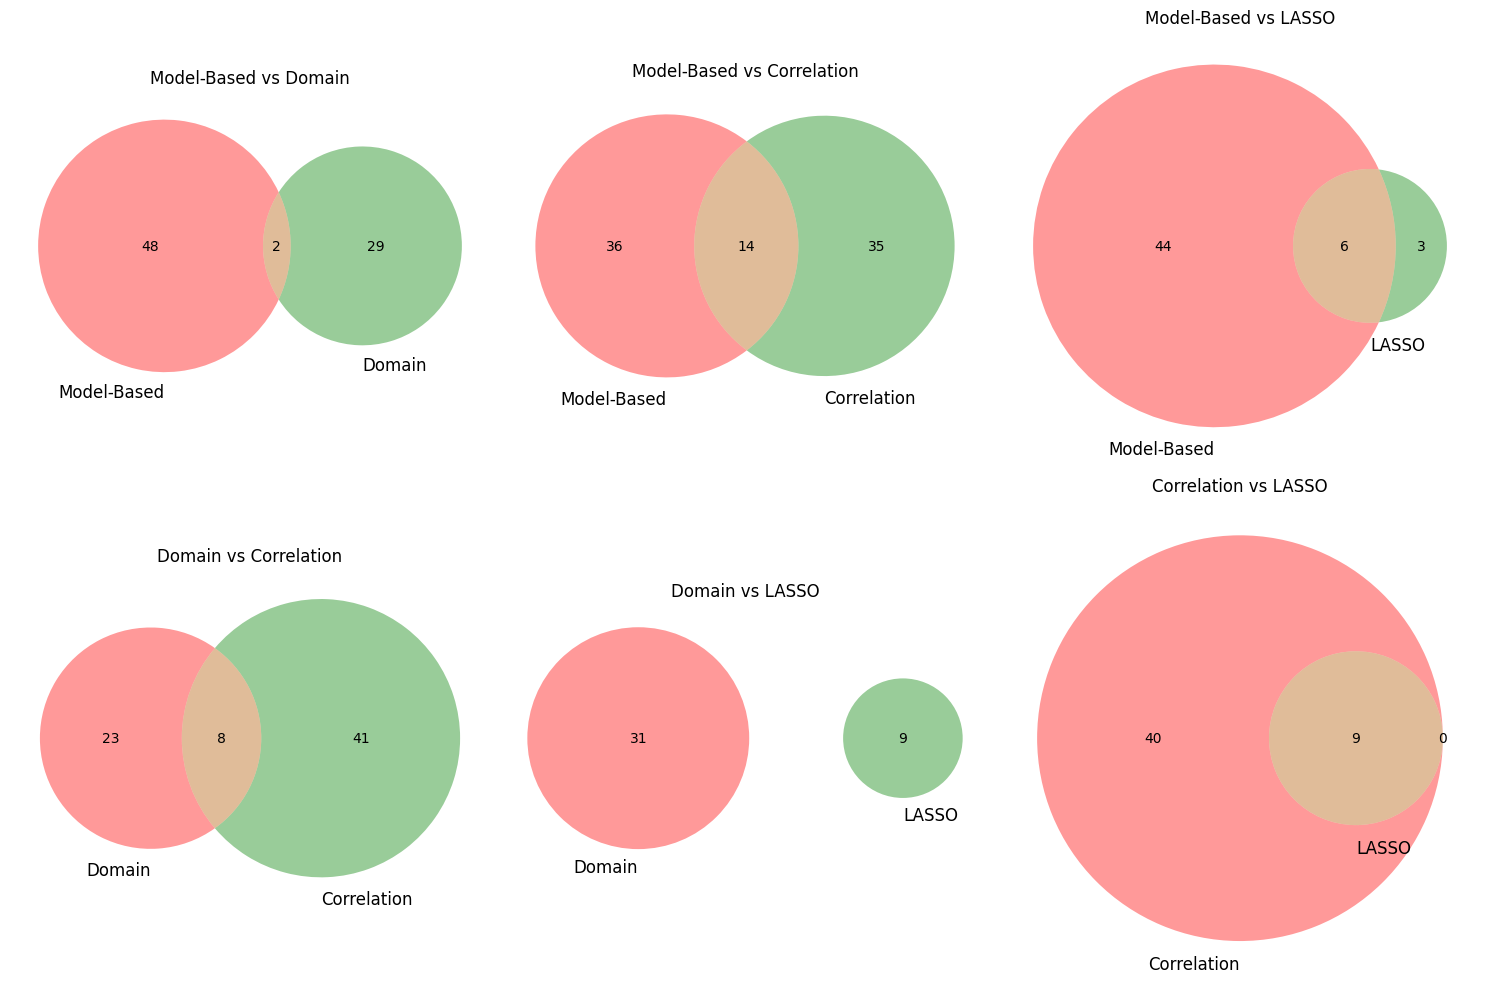

In [3]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from itertools import combinations

# Prepare method pairs
method_pairs = list(combinations(feature_sets.keys(), 2))

# Set up grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot all pairwise Venn diagrams
for i, (method1, method2) in enumerate(method_pairs):
    set1 = set(feature_sets[method1])
    set2 = set(feature_sets[method2])
    
    plt.sca(axes[i])
    venn2([set1, set2], set_labels=(method1, method2))
    axes[i].set_title(f"{method1} vs {method2}")

# Turn off unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


---

# Kidney Disease

---

In [8]:
import joblib 

diagnosis = 'kidney_disease'

loaded_model = joblib.load("saved_models/XGBoost_kidney.pkl")
feature_names = joblib.load("saved_models/kidney_feature_names.pkl")

importances = loaded_model.feature_importances_
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Model  importance
model_based_features=[]
for feature, importance in feature_importance[:50]:
    model_based_features.append(feature)

# Correlation based
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import re
from sklearn.impute import KNNImputer, SimpleImputer
from dataset_processing import get_columns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import joblib

# Load dataset
df = pd.read_csv('NHANES_SAMPLE.csv')

# Define target column
target_column, remove_list = get_columns('kidney_conditions')

# Ensure target column exists
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset!")

# Handle missing target values
df = df.dropna(subset=[target_column])

# Convert target column to binary classification (1 = diabetes, else 0)
df[target_column] = df[target_column].apply(lambda x: 1 if x == 1 else 0)

# Convert all byte-string values to normal strings
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Select all feature columns (excluding target)
feature_columns = [col for col in df.columns if col != target_column]
feature_columns = [col for col in df.columns if col not in remove_list]

# Define activity columns to combine
activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]
# Combine activity columns
for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        combined_col = f"{freq_col}_combined"
        df[combined_col] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)
        df.drop([freq_col, unit_col], axis=1, inplace=True)
        feature_columns.remove(freq_col)
        feature_columns.remove(unit_col)
        feature_columns.append(combined_col)


df =df[feature_columns]

# Separate categorical and numerical columns
categorical_cols = df[feature_columns].select_dtypes(include=['object']).columns.tolist()
numerical_cols = [col for col in feature_columns if col not in categorical_cols]

from sklearn.preprocessing import OrdinalEncoder

# Initialize the encoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Encode only the categorical columns
df[categorical_cols] = ordinal_encoder.fit_transform(df[categorical_cols]) + 1  # shift to start at 1

# Save the encoder for future use if needed

# Handle missing values using KNN imputer
knn_imputer = KNNImputer(n_neighbors=3) 
# df.fillna(df.median(), inplace=True)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)

df.columns = [col.replace("_", "") for col in df.columns]
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = df.drop(columns=[target_column])

y = df[target_column]

X_corr = X.copy()
X_corr[target_column] = y

# Compute correlation with target
correlations = X_corr.corr(numeric_only=True)[target_column].abs()

# Select top-k features based on correlation
top_k = 50
top_corr_features = correlations.sort_values(ascending=False).head(top_k).index.tolist()

# Remove the target itself from the list
top_corr_features = [f for f in top_corr_features if f != target_column]


# Lasso - based 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Lasso (L1) Logistic Regression
lasso = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, C=0.01, random_state=42)
lasso.fit(X_scaled, y)

# Extract non-zero coefficients
lasso_selected_features = X.columns[(lasso.coef_ != 0).ravel()].tolist()


# Domain-based knowledge
domain_based_features = pd.read_csv('kidney_disease.csv')
domain_based_features=domain_based_features['column'].tolist()

for col in X.columns:
    if 'combined' in col:
        domain_based_features.append(col)

activity_columns = ["PAD790Q", "PAD790U", "PAD810Q", "PAD810U"]

for col in activity_columns:
    domain_based_features.remove(col)

/tmp/ipykernel_3799306/2137368161.py:88: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)



Total unique features selected across all methods (117): 117


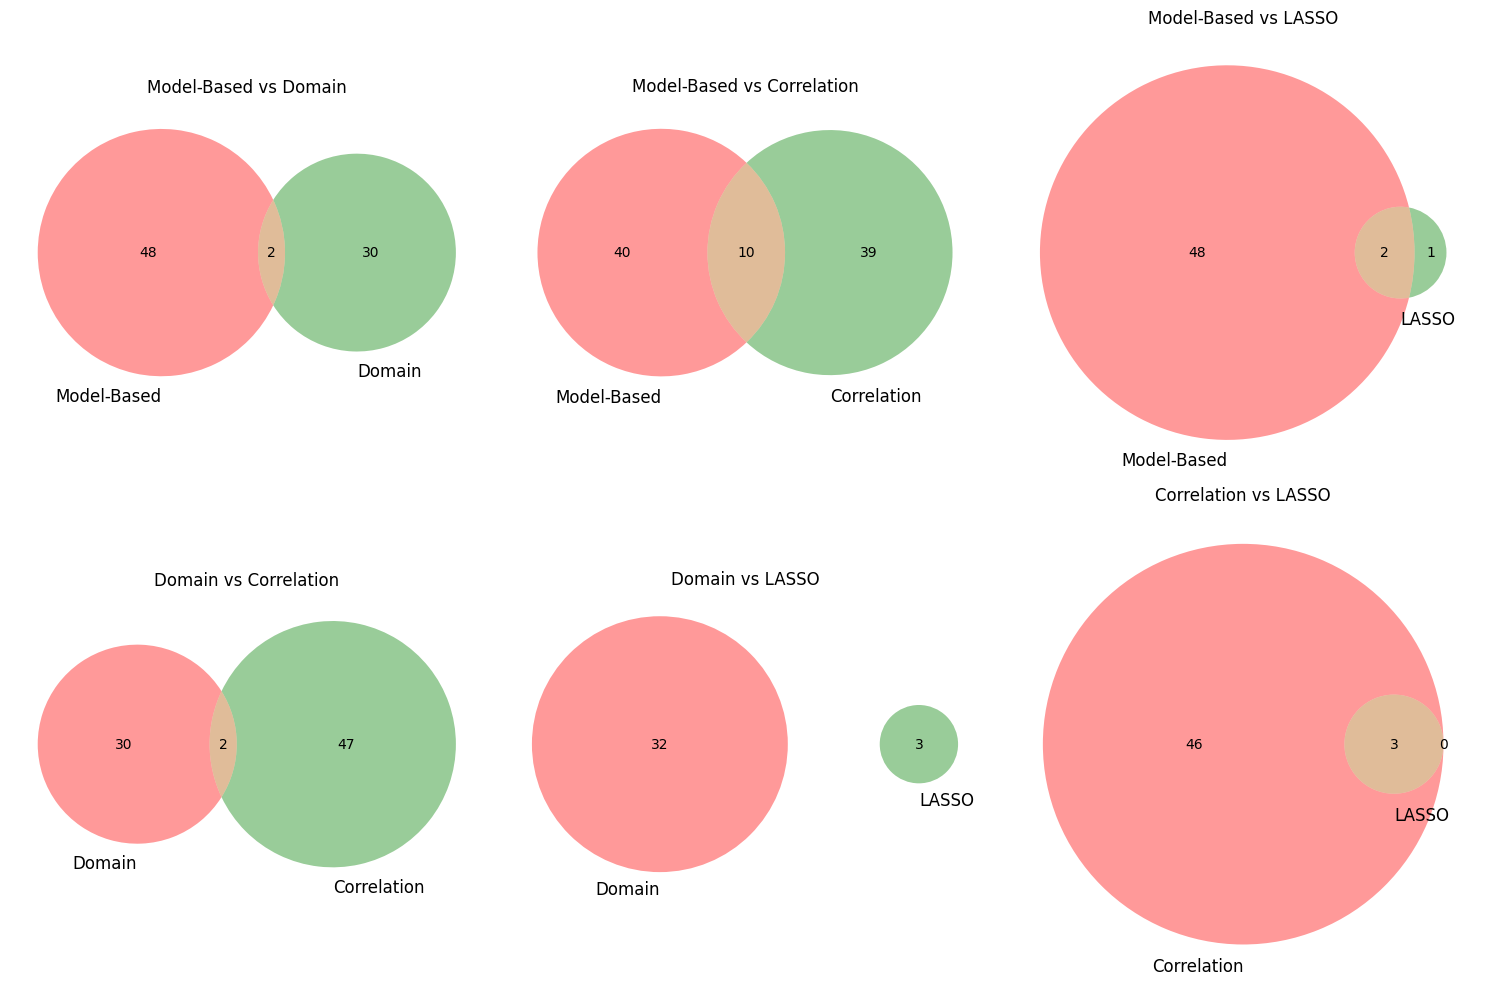

In [9]:
from functools import reduce

# Collect all methods
feature_sets = {
    "Model-Based": model_based_features,  # already extracted and saved
    "Domain": domain_based_features,
    "Correlation": top_corr_features,
    "LASSO": lasso_selected_features,
}


# Union of all features
union = list(set.union(*map(set, feature_sets.values())))
print(f"\nTotal unique features selected across all methods ({len(union)}):", len(union))


import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from itertools import combinations

# Prepare method pairs
method_pairs = list(combinations(feature_sets.keys(), 2))

# Set up grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot all pairwise Venn diagrams
for i, (method1, method2) in enumerate(method_pairs):
    set1 = set(feature_sets[method1])
    set2 = set(feature_sets[method2])
    
    plt.sca(axes[i])
    venn2([set1, set2], set_labels=(method1, method2))
    axes[i].set_title(f"{method1} vs {method2}")

# Turn off unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()



In [10]:
import pickle 
with open('feature_sets_kidney.pkl', 'wb') as f:
    pickle.dump(feature_sets, f)


---

# CVD

---

In [11]:
import joblib 

diagnosis = 'cvd'

loaded_model = joblib.load("saved_models/XGBoost_cvd.pkl")
feature_names = joblib.load("saved_models/cvd_feature_names.pkl")

importances = loaded_model.feature_importances_
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Model  importance
model_based_features=[]
for feature, importance in feature_importance[:50]:
    model_based_features.append(feature)

# Correlation based
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import re
from sklearn.impute import KNNImputer, SimpleImputer
from dataset_processing import get_columns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import joblib

# Load dataset
df = pd.read_csv('NHANES_SAMPLE.csv')

# Define target column
target_column, remove_list = get_columns('cvd')

# Ensure target column exists
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset!")

# Handle missing target values
df = df.dropna(subset=[target_column])

# Convert target column to binary classification (1 = diabetes, else 0)
df["target"] = df[remove_list].apply(lambda row: 1 if (row == 1).any() else 0, axis=1)
target_column = "target"

# Convert target column to binary classification (1 = diabetes, else 0)

# Convert all byte-string values to normal strings
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Select all feature columns (excluding target)
feature_columns = [col for col in df.columns if col != target_column]
feature_columns = [col for col in df.columns if col not in remove_list]

# Define activity columns to combine
activity_columns = [("PAD790Q", "PAD790U"), ("PAD810Q", "PAD810U")]
# Combine activity columns
for freq_col, unit_col in activity_columns:
    if freq_col in df.columns and unit_col in df.columns:
        combined_col = f"{freq_col}_combined"
        df[combined_col] = df[freq_col].astype(str) + "_" + df[unit_col].astype(str)
        df.drop([freq_col, unit_col], axis=1, inplace=True)
        feature_columns.remove(freq_col)
        feature_columns.remove(unit_col)
        feature_columns.append(combined_col)


df =df[feature_columns]

# Separate categorical and numerical columns
categorical_cols = df[feature_columns].select_dtypes(include=['object']).columns.tolist()
numerical_cols = [col for col in feature_columns if col not in categorical_cols]

from sklearn.preprocessing import OrdinalEncoder

# Initialize the encoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Encode only the categorical columns
df[categorical_cols] = ordinal_encoder.fit_transform(df[categorical_cols]) + 1  # shift to start at 1

# Save the encoder for future use if needed

# Handle missing values using KNN imputer
knn_imputer = KNNImputer(n_neighbors=3) 
# df.fillna(df.median(), inplace=True)
df = df.dropna(axis=1, how='all')
df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)

df.columns = [col.replace("_", "") for col in df.columns]
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = df.drop(columns=[target_column])

y = df[target_column]

X_corr = X.copy()
X_corr[target_column] = y

# Compute correlation with target
correlations = X_corr.corr(numeric_only=True)[target_column].abs()

# Select top-k features based on correlation
top_k = 50
top_corr_features = correlations.sort_values(ascending=False).head(top_k).index.tolist()

# Remove the target itself from the list
top_corr_features = [f for f in top_corr_features if f != target_column]


# Lasso - based 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Lasso (L1) Logistic Regression
lasso = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, C=0.01, random_state=42)
lasso.fit(X_scaled, y)

# Extract non-zero coefficients
lasso_selected_features = X.columns[(lasso.coef_ != 0).ravel()].tolist()


# Domain-based knowledge
domain_based_features = pd.read_csv('cvd.csv')
domain_based_features=domain_based_features['column'].tolist()

for col in X.columns:
    if 'combined' in col:
        domain_based_features.append(col)

activity_columns = ["PAD790Q", "PAD790U", "PAD810Q", "PAD810U"]

for col in activity_columns:
    domain_based_features.remove(col)

/tmp/ipykernel_3799306/2202723508.py:91: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df[:] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns, index=df.index)



Total unique features selected across all methods (115): 115


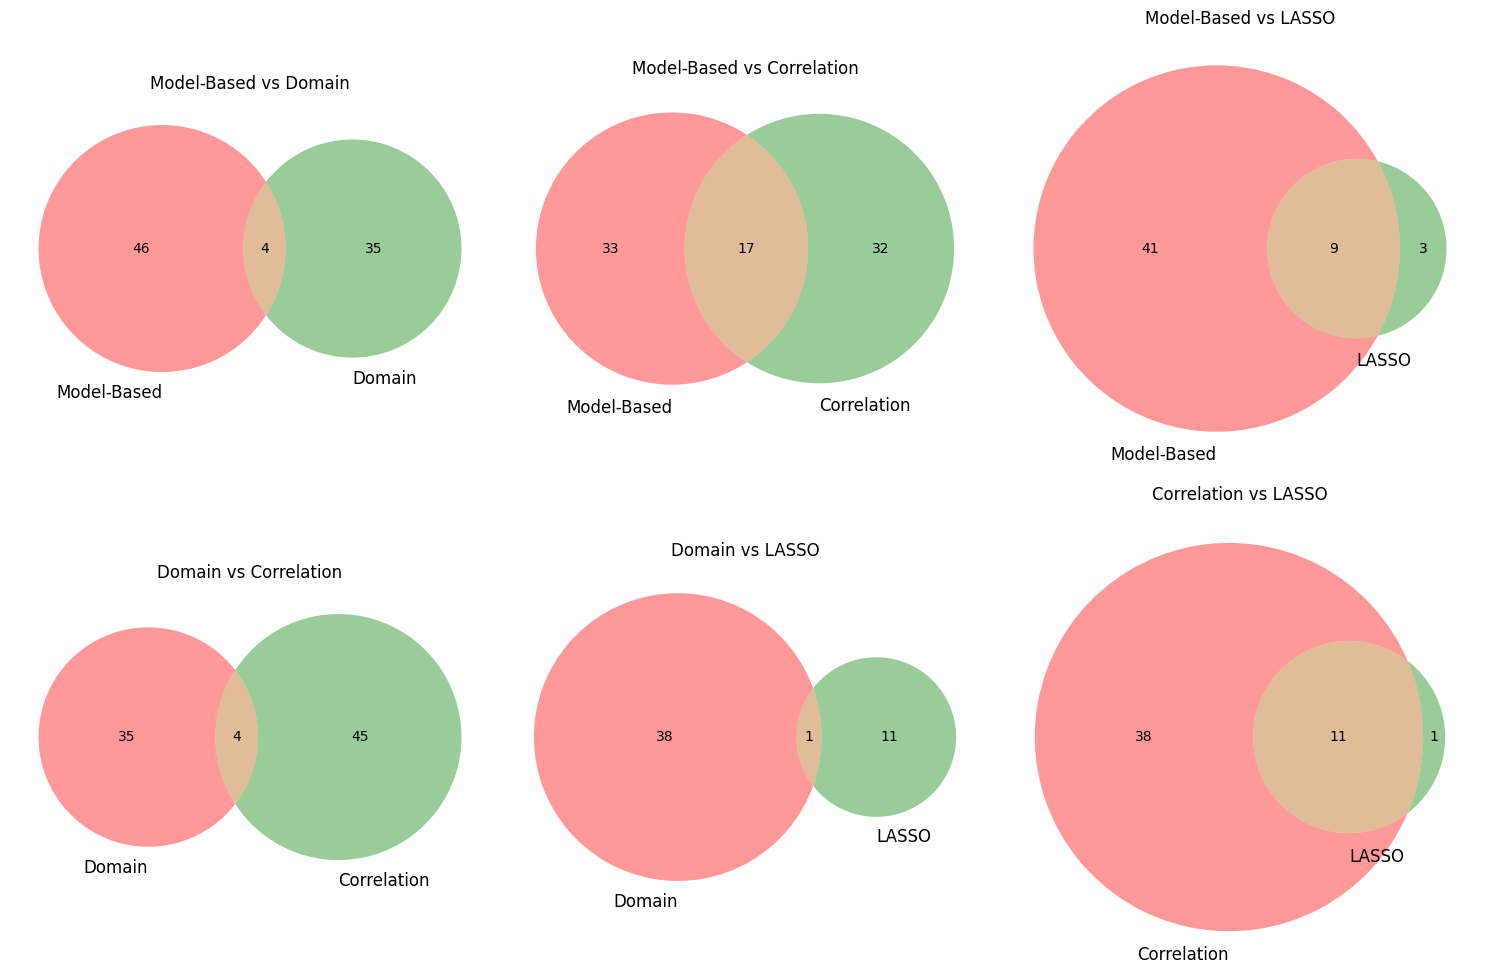

In [12]:
from functools import reduce

# Collect all methods
feature_sets = {
    "Model-Based": model_based_features,  # already extracted and saved
    "Domain": domain_based_features,
    "Correlation": top_corr_features,
    "LASSO": lasso_selected_features,
}


# Union of all features
union = list(set.union(*map(set, feature_sets.values())))
print(f"\nTotal unique features selected across all methods ({len(union)}):", len(union))


import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from itertools import combinations

# Prepare method pairs
method_pairs = list(combinations(feature_sets.keys(), 2))

# Set up grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot all pairwise Venn diagrams
for i, (method1, method2) in enumerate(method_pairs):
    set1 = set(feature_sets[method1])
    set2 = set(feature_sets[method2])
    
    plt.sca(axes[i])
    venn2([set1, set2], set_labels=(method1, method2))
    axes[i].set_title(f"{method1} vs {method2}")

# Turn off unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()



In [13]:
import pickle 
with open('feature_sets_cvd.pkl', 'wb') as f:
    pickle.dump(feature_sets, f)
